# Sipe efficacy factor with varying electron density

The efficacy factor used to predict LIPSS formation is dependent on the material's permittivity and, consequently, the conduction band electron density induced by laser energy absorption.This code takes an input LIPSS period and calculates the efficacy factor over a range of electron densities. It then finds the electron density that best matches the observed period.

## Imports and plot settings

In [1]:
from math import *
import cmath
from cmath import sqrt
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import sys
import os

#Import custom modules
from physics import *
from Sipe_Functions import *

sns.set(font_scale=2.0)
sns.set_style("ticks")
sns.set_palette(palette='deep')
sns.set_color_codes(palette='deep')
mpl.rcParams.update({'font.family': 'serif', 'font.serif':'DejaVu Serif'})

%matplotlib notebook

/home/drake/.anaconda3/lib/python3.4/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


## Input parameters

In [30]:
#Laser parameters
theta = 0.0 #angle of incidence in degrees
wavelength = 2.4 #laser wavelength in um
polarization = 'p'
Fluence = 0.36 #Laser fluence in J/cm^2 (0.38, 0.36,0.35,0.38)
tp = 100.0*10**-15 #Pulse duration in s
I = Fluence/tp #Laser intensity in W/cm^2

#Material parameters

#non-excited refractive index of Ge (from refractiveindex.info, units in um)
n0 = sqrt(9.28156 + 6.72880*wavelength**2/(wavelength**2-0.44105) + 0.21307*wavelength**2/(wavelength**2-3870.1))
epsilonc = n0**2 #non-excited permittivity

ObservedPeriod = 0.850 #Observed HSFL period in um (0.738, 0.850, 0.926, 0.950)
ObservedPeriodErr = 0.05 #Observed HSFL period in um (0.03, 0.05, 0.03, 0.05)
meff = 0.081*me #effective mass
tau = 46.0 #electron collision time in fs
chi3 = 0*2.27*10**-19 #Third-order nonlinear susceptibility in m^2/V^2 (2.27, 14.72, 12.00, 8.37 for 2, 2.4, 3.0, 3.6 um, respectively)
n2 = 3*chi3/(4*epsilon0*c*n0**2)*10**4 #second-order nonlinear refractive index in cm^2/W
s = 0.4 #surface shape factor
f = 0.7 #surface filling factor

#Kerr effect:
epsilonKerr = 2*n0*n2*I #+ (n2*I)**2

#convert to base units
theta *= 2*pi/360
wavelength *= 10**-6
ObservedPeriod *= 10**-6
tau *= 10**-15

#Calculated constants
omega = 2*pi*c/wavelength
ncritmod = epsilon0*meff/q**2*(omega**2+1/tau**2)*(epsilonc+2*n0*n2*I+(n2*I)**2)
ncritmod = ncritmod.real

#Calculation parameters
kmax = 5 #Maximum wavevector
numpoints_k = 500 #Number of wavevector points to calculate

nemin = 0.5*10**20 #Minimum electron density
nemax = 2.0*10**20 #Maximum electron density
numpoints_ne = 500 #Number of electron density points to calculate

## Calculate efficacy over range of wavevectors and electron densities

In [31]:
efficacy = np.zeros((numpoints_ne,numpoints_k))
ElectronDensity = np.linspace(nemin,nemax,numpoints_ne)*10**6 #Convert to base units
wavevector = np.linspace(0.01,kmax,numpoints_k)
ElectronDensityGrid, wavevectorGrid = np.meshgrid(ElectronDensity,wavevector, indexing='ij')

omegap = np.sqrt(ElectronDensityGrid*q**2/(meff*epsilon0)) #Plasma frequency
epsilonDrude = -omegap**2/(omega*(omega+1.0j/tau)) #Permittivity change due to ionization
epsilon = epsilonc + epsilonKerr + epsilonDrude #Overall permittivity
PermittivityReal = epsilon[:,0].real
PermittivityImag = epsilon[:,0].imag

if polarization == 'p':
    kx = wavevectorGrid
    ky = np.zeros(wavevectorGrid.shape)
elif polarization == 's':
    kx = np.zeros(wavevectorGrid.shape)
    ky = wavevectorGrid
else:
    print('Polarization must be s or p')
    
efficacy = eta(epsilon,s,f,kx,ky,theta,polarization=polarization)

ElectronDensity *= 10**-6 #Convert back to cm^-3

## Search through efficacy array for local maxima to determine the period predicted at each electron density

In [32]:
PredictedPeriod = np.zeros(numpoints_ne)
for i in range(numpoints_ne):
    #Find elements of local maxima
    LocalMaxima = FindMaxima(efficacy[i,:])

    #Find value of k at last local maxima
    PredictedWavevector = wavevector[LocalMaxima[-1]]
    PredictedPeriod[i] = wavelength/PredictedWavevector

PredictedPeriodSmoothed = np.multiply(savitzky_golay(PredictedPeriod,order=2,window_size=15),10**6)
dne_dPeriod = np.diff(ElectronDensity)/np.diff(PredictedPeriodSmoothed)

## Find the element of the predicted period array that best matches the observed period

In [33]:
MatchingElement=0
while PredictedPeriod[MatchingElement]<ObservedPeriod:
    if MatchingElement<numpoints_ne-1:
        MatchingElement+=1
    else:
        print('Observed period not reached.')
        break
nePredicted = (ElectronDensity[MatchingElement-1]+ElectronDensity[MatchingElement])/2
nePredictedErr = sqrt(((dne_dPeriod[MatchingElement]+dne_dPeriod[MatchingElement+1])/2)**2*ObservedPeriodErr**2).real

epsilonPredictedReal = (PermittivityReal[MatchingElement-1] + PermittivityReal[MatchingElement])/2
epsilonPredictedImag = (PermittivityImag[MatchingElement-1] + PermittivityImag[MatchingElement])/2
epsilonPredicted = epsilonPredictedReal + epsilonPredictedImag*1.0j
print('Electron density that best matches observed HSFL period: {ElectronDensity} +/- {ElectronDensityError} \
cm^-3'.format(ElectronDensity='%.2e'%(nePredicted),ElectronDensityError='%.2e'%(nePredictedErr)))
print('Error =',nePredictedErr/nePredicted*100,'%')
print('Scaled to modified critical density: {ElectronDensity}'.format(ElectronDensity=\
                                                                      '%.2e'%(nePredicted/ncritmod*10**6)))
print('Corresponding permittivity:', epsilonPredicted)
print('Corresponding refractive index:', cmath.sqrt(epsilonPredicted))

Electron density that best matches observed HSFL period: 1.28e+20 +/- 1.53e+19 cm^-3
Error = 11.9142018878 %
Scaled to modified critical density: 4.94e-01
Corresponding permittivity: (8.39044958626+0.226498343731j)
Corresponding refractive index: (2.8968910708117743+0.03909334838522505j)


## Contour plot of efficacy vs electron density and wavevector

<IPython.core.display.Javascript object>


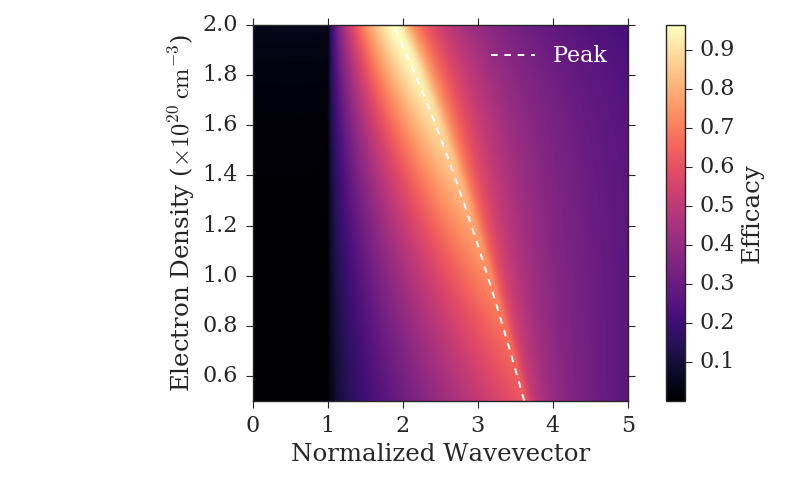

In [34]:
plt.figure(figsize=(10,6))
#plt.pcolormesh(wavevector,ElectronDensity,efficacy,cmap='magma',shading='gouraud')
plt.imshow(np.flipud(efficacy),cmap='magma',extent=[0,kmax,nemin*10**-20,nemax*10**-20],aspect=kmax/(nemax-nemin)*10**20)
plt.plot(wavelength/PredictedPeriodSmoothed*10**6,ElectronDensity*10**-20,color='w',label='Peak',linestyle='--')

#Lines and arrows for clarification in paper
#plt.axvline(wavelength/ObservedPeriod,linestyle=':',color='k',linewidth=3)
#plt.axhline(nePredicted/10**20,linestyle=':',color='g',linewidth=3)
#plt.arrow(wavelength/ObservedPeriod, nemin*10**-20, 0, (nemax-nemin)*10**-20/8, width=0.05, head_width=0.25, head_length=0.15, fc='k', ec='k')
#plt.arrow(wavelength/ObservedPeriod, nePredicted*10**-20, -(wavelength/ObservedPeriod-kmax/2.5), 0, width=0.02, head_width=0.1, head_length=0.35, fc='g', ec='g')

plt.ylim(nemin*10**-20,nemax*10**-20)
plt.xlabel('Normalized Wavevector')
plt.ylabel('Electron Density ($\\times 10^{20} \: \mathrm{cm}^{-3}$)')
colorbar = plt.colorbar()
colorbar.set_label('Efficacy')
plt.tight_layout()

leg = plt.legend(framealpha = 0, loc = 'best')
for text in leg.get_texts():
    plt.setp(text, color = 'w')
    
#plt.savefig('Efficacy_ne_dependence.svg')

#3D plot of the above, if desired
#fig = plt.figure()
#wavevector2D, ElectronDensity2D = np.meshgrid(wavevector, ElectronDensity)
#ax = fig.gca(projection='3d')
#surf = ax.plot_surface(wavevector2D,ElectronDensity2D,efficacy, rstride=1, cstride=1, cmap='magma', linewidth=0)

## Plot electron density vs HSFL period

Also plots the observed period as a single data point. This gives you an idea of how well the code was able to match it or, if it didn't, whether you need to increase or decrease the electron density.

<IPython.core.display.Javascript object>


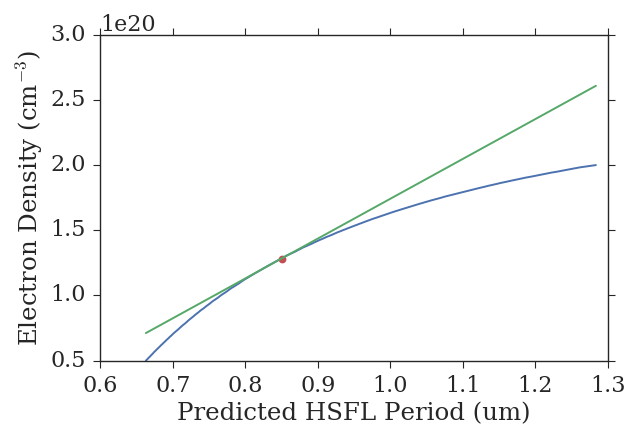

In [35]:
plt.figure()
plt.plot(PredictedPeriodSmoothed,ElectronDensity)
plt.plot(ObservedPeriod*10**6,nePredicted,'ro')

#Plot tangent line at observed period
m = (dne_dPeriod[MatchingElement]+dne_dPeriod[MatchingElement+1])/2
b = nePredicted - m*ObservedPeriod*10**6
plt.plot(PredictedPeriodSmoothed,m*PredictedPeriodSmoothed+b)

plt.ylabel('Electron Density (cm$^{-3}$)')
plt.xlabel('Predicted HSFL Period (um)')
plt.tight_layout()

## Plot efficacy vs wavevector at the predicted electron density

Predicted HSFL period = 0.851063829787 μm
Observed HSFL period = 0.8499999999999999 μm


<IPython.core.display.Javascript object>


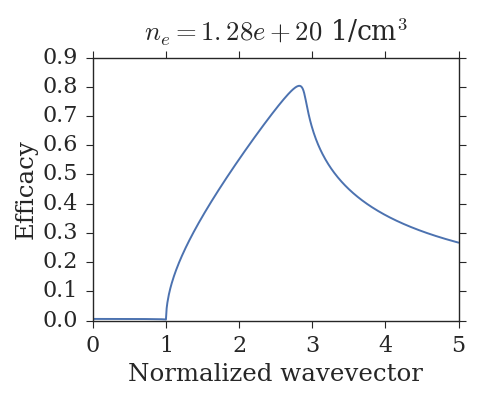

In [36]:
print('Predicted HSFL period =',PredictedPeriod[MatchingElement]*10**6,'μm')
print('Observed HSFL period =',ObservedPeriod*10**6,'μm')
plt.figure(figsize=(6,5))
plt.plot(wavevector,efficacy[MatchingElement,:])
plt.xlabel('Normalized wavevector')
plt.ylabel('Efficacy')
plt.title('$n_e={ne}$ 1/cm$^3$'.format(ne='%.2e'%(nePredicted)),y=1.04)
plt.tight_layout()